In [2]:
import random

import numpy as np
import skimage.transform as transform
from skimage.io import imread


class Reader:
    def __init__(self, image_list, labels_list=[], scale=1):
        assert isinstance(scale, int)
        if len(labels_list) is not 0:
            assert len(image_list) == len(labels_list)

        self.scale = scale

        self.images = image_list
        self.labels = labels_list

        self.train_probabilities = np.ones(len(image_list)) / float(len(image_list))

        self.cache = {}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        if idx not in self.cache:
            rgb = imread(self.images[idx], plugin='pil')
            rgb = transform.resize(rgb, np.array(rgb.shape[:2]) / self.scale,   mode='constant')

            label = None
            if idx < len(self.labels):
                # skimage.io.imread(fname, as_gray=False, plugin=None, **plugin_args)
                label = imread(self.labels[idx], True, plugin='pil')  # False -> 원본 3채널 이미지로
                label = np.digitize(label,bins=np.unique(label))-1
                label = label[::self.scale, ::self.scale]
                label = label[:rgb.shape[0], :rgb.shape[1]]

            self.cache[idx] = (rgb.astype(np.float32), label.astype(np.int32))

        return self.cache[idx]

    
    def create_batch_generator(self, batch_size=3, transforms=[]):
        assert len(self.images) == len(self.labels)

        def f():
            images = []
            labels = []

            for t in transforms:
                if hasattr(t, 'prepare'):
                    t.prepare()

            for index in range(batch_size):
                idx = np.random.choice(range(len(self.images)), 1, p=self.train_probabilities)[0]
                i, l = self[idx]

                for t in transforms:
                    seed = random.randint(0, 2 ** 32 - 1)
                    np.random.seed(seed)
                    i = t(i, True)
                    np.random.seed(seed)
                    l = t(l)

                images.append(np.expand_dims(i.transpose(2, 0, 1), 0))
                labels.append(np.expand_dims(l, 0))

            labels = np.vstack(labels)

            return np.vstack(images).astype(np.float32), labels.astype(np.int32)

        return f

In [13]:
import os
from os import listdir
from os.path import join
import argparse

import numpy
import torch

import random

import numpy as np
import skimage.transform as transform
from skimage.io import imread

basepath = 'E:/CVPPP2017_LSC_training/images/A1'

rgb = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_rgb.png')])
labels = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_label.png')])

numpy.random.seed(1203412412)
indexes = numpy.random.permutation(len(rgb))
perm_rgb = numpy.array(rgb)[indexes].tolist()
perm_labels = numpy.array(labels)[indexes].tolist()

train_data = Reader(perm_rgb[:-10], perm_labels[:-10], 1)  # (530, 500, 4) / (530, 500)
valid_data = Reader(perm_rgb[-10:], perm_labels[-10:], 1)


import utils as dc

transforms = [dc.rgba2rgb(),
              dc.clip_patch((448, 448)),
              dc.flip_horizontally(),
              dc.flip_vertically(),
              dc.rotate90(),
              dc.random_transform(0.1, 90, 0),
              dc.blur(),
              dc.normalize(0.5, 0.5)]

train_generator = train_data.create_batch_generator(40, transforms=transforms)  # batch_size

(40, 3, 448, 448)
(40, 448, 448)


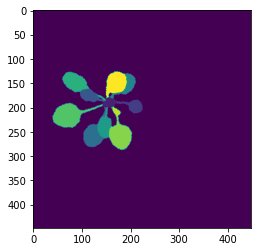

In [14]:
import matplotlib.pyplot as plt

x, y = train_generator()
print(x.shape)
print(y.shape)

# labels, halo, objects = mask_builder(y)
plt.imshow(y[0])

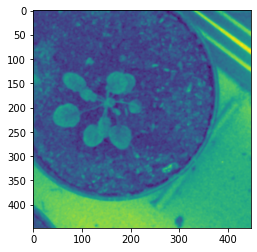

In [15]:
plt.imshow(x[0][0])

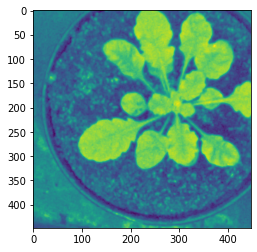

In [22]:
plt.imshow(x[20][1])

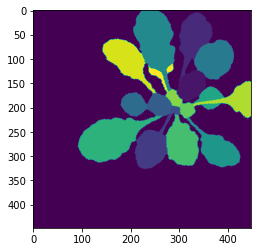

In [21]:
plt.imshow(y[20])

In [18]:
import warnings

import numpy
import torch
import torch.nn.functional as F

# http://devdoc.net/python/scikit-image-doc-0.13.1/api/skimage.draw.html#skimage.draw.circle
# from skimage.draw import circle  0.16.2
from skimage.draw import circle_perimeter  # 0.19.2

In [43]:
import numpy as np

# https://github.com/scikit-image/scikit-image/blob/v0.13.1/skimage/draw/draw.py#L144
def _ellipse_in_shape(shape, center, radii, rotation=0.):
    r_lim, c_lim = np.ogrid[0:float(shape[0]), 0:float(shape[1])]
    r_org, c_org = center
    r_rad, c_rad = radii
    rotation %= np.pi
    sin_alpha, cos_alpha = np.sin(rotation), np.cos(rotation)
    r, c = (r_lim - r_org), (c_lim - c_org)
    distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \
                + ((r * sin_alpha - c * cos_alpha) / c_rad) ** 2
    return np.nonzero(distances < 1)


def ellipse(r, c, r_radius, c_radius, shape=None, rotation=0.):

    center = np.array([r, c])
    radii = np.array([r_radius, c_radius])
    # allow just rotation with in range +/- 180 degree
    rotation %= np.pi

    # compute rotated radii by given rotation
    r_radius_rot = abs(r_radius * np.cos(rotation)) \
                   + c_radius * np.sin(rotation)
    c_radius_rot = r_radius * np.sin(rotation) \
                   + abs(c_radius * np.cos(rotation))
    # The upper_left and lower_right corners of the smallest rectangle
    # containing the ellipse.
    radii_rot = np.array([r_radius_rot, c_radius_rot])
    upper_left = np.ceil(center - radii_rot).astype(int)
    lower_right = np.floor(center + radii_rot).astype(int)

    if shape is not None:
        # Constrain upper_left and lower_right by shape boundary.
        upper_left = np.maximum(upper_left, np.array([0, 0]))
        lower_right = np.minimum(lower_right, np.array(shape[:2]) - 1)

    shifted_center = center - upper_left
    bounding_shape = lower_right - upper_left + 1

    rr, cc = _ellipse_in_shape(bounding_shape, shifted_center, radii, rotation)
    rr.flags.writeable = True
    cc.flags.writeable = True
    rr += upper_left[0]
    cc += upper_left[1]
    return rr, cc


def circle(r, c, radius, shape=None):
    return ellipse(r, c, radius, radius, shape)

In [7]:
fixed_depth = 30  # Max # of object in a training batch
margin = 21  # size of margin (dilation)
min_fragment = 10  # minimal size of an object in pixels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
rr, cc = circle(margin / 2, margin / 2, margin / 2 + 1, shape=(margin, margin))  
structure_element = numpy.zeros((margin, margin))
structure_element[rr, cc] = 1
structure_element = numpy.repeat(numpy.expand_dims(numpy.expand_dims(structure_element, 0), 0), fixed_depth, 0)

sel = torch.from_numpy(structure_element).float().to(device)

print('rr :', rr.shape)
print('cc :', cc.shape)
print('structure_element :', structure_element.shape)
print('sel :', sel.shape)

rr : (388,)
cc : (388,)
structure_element : (30, 1, 21, 21)
sel : torch.Size([30, 1, 21, 21])


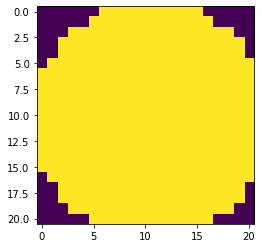

In [9]:
import matplotlib.pyplot as plt

structure_element = numpy.zeros((margin, margin))
structure_element[rr, cc] = 1

plt.imshow(structure_element)

In [10]:
label = y  # (N, 192, 192)

back = numpy.zeros((label.shape[0], fixed_depth, label.shape[1], label.shape[2]))  # (N, 30, 192, 192)
object_list = []
for i in range(label.shape[0]):  # i: batch_idx
    # Count # of occurrences of each value in array of non-negative ints.
    bincount = numpy.bincount(label[i].flatten())  # 192x192=36864
    pixels = numpy.where(bincount > min_fragment)[0]  # 충분히 넓은 픽셀 영역만 obj로 간주
    if len(pixels) > fixed_depth:  # 선별된 obj개수가 지정된 수를 초과하면
        pixels = pixels[:fixed_depth]
        warnings.warn("Not all objects fits in fixed depth", RuntimeWarning)

    for l, v in enumerate(pixels):  # len(pixels)<=fixed_depth
        back[i, l, label[i] == v] = 1.
    object_list.append(numpy.array(range(l + 1)))

labels = torch.from_numpy(back).float().to(device)
masks = F.conv2d(labels, sel, padding='same', groups=fixed_depth)

print('labels :', labels.shape)
print('masks :', masks.shape)

labels : torch.Size([40, 30, 448, 448])
masks : torch.Size([40, 30, 448, 448])


In [11]:
masks[masks > 0] = 1.
masks[labels > 0] = 2.
masks[:, 0, :, :] = 1.

weights = masks.sum(-1, keepdim=True).sum(-2, keepdim=True)
weights[weights==0.] = 1.
        
masks = masks / weights

In [12]:
labels.shape

torch.Size([40, 30, 448, 448])

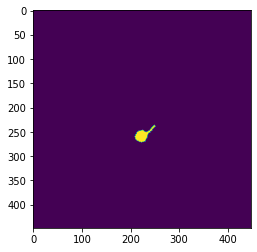

In [13]:
plt.imshow(labels[0][2].cpu().numpy())

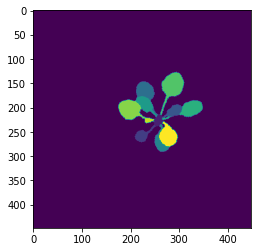

In [14]:
plt.imshow(y[0])

In [15]:
import warnings

import numpy as np
import torch
import torch.nn.functional as F

# http://devdoc.net/python/scikit-image-doc-0.13.1/api/skimage.draw.html#skimage.draw.circle
# from skimage.draw import circle  0.16.2
# from skimage.draw import circle_perimeter  # 0.19.2

# Same as from skimage.draw import circle  0.16.2
# https://github.com/scikit-image/scikit-image/blob/v0.13.1/skimage/draw/draw.py#L144
def _ellipse_in_shape(shape, center, radii, rotation=0.):
    r_lim, c_lim = np.ogrid[0:float(shape[0]), 0:float(shape[1])]
    r_org, c_org = center
    r_rad, c_rad = radii
    rotation %= np.pi
    sin_alpha, cos_alpha = np.sin(rotation), np.cos(rotation)
    r, c = (r_lim - r_org), (c_lim - c_org)
    distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \
                + ((r * sin_alpha - c * cos_alpha) / c_rad) ** 2
    return np.nonzero(distances < 1)


def ellipse(r, c, r_radius, c_radius, shape=None, rotation=0.):

    center = np.array([r, c])
    radii = np.array([r_radius, c_radius])
    # allow just rotation with in range +/- 180 degree
    rotation %= np.pi

    # compute rotated radii by given rotation
    r_radius_rot = abs(r_radius * np.cos(rotation)) \
                   + c_radius * np.sin(rotation)
    c_radius_rot = r_radius * np.sin(rotation) \
                   + abs(c_radius * np.cos(rotation))
    # The upper_left and lower_right corners of the smallest rectangle
    # containing the ellipse.
    radii_rot = np.array([r_radius_rot, c_radius_rot])
    upper_left = np.ceil(center - radii_rot).astype(int)
    lower_right = np.floor(center + radii_rot).astype(int)

    if shape is not None:
        # Constrain upper_left and lower_right by shape boundary.
        upper_left = np.maximum(upper_left, np.array([0, 0]))
        lower_right = np.minimum(lower_right, np.array(shape[:2]) - 1)

    shifted_center = center - upper_left
    bounding_shape = lower_right - upper_left + 1

    rr, cc = _ellipse_in_shape(bounding_shape, shifted_center, radii, rotation)
    rr.flags.writeable = True
    cc.flags.writeable = True
    rr += upper_left[0]
    cc += upper_left[1]
    return rr, cc


def circle(r, c, radius, shape=None):
    return ellipse(r, c, radius, radius, shape)

In [16]:
def flatten(x):
    return x.view(x.size(0), -1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def build_halo_mask(fixed_depth=30, margin=21, min_fragment=10):
    """
    Function builds a configuration for halo region building
    :param fixed_depth: Maximum object on an image
    :param margin: The size of halo region
    :param min_fragment: Minimal size of an object on the image
    :return: a function for generation labels, masks and object_lists used by halo loss
    """
    assert margin % 2 is not 0, "Margin should be odd"

    rr, cc = circle(margin / 2, margin / 2, margin / 2 + 1, shape=(margin, margin))
    structure_element = numpy.zeros((margin, margin))
    structure_element[rr, cc] = 1
    structure_element = numpy.repeat(numpy.expand_dims(numpy.expand_dims(structure_element, 0), 0), fixed_depth, 0)

    sel = torch.from_numpy(structure_element).float().to(device)

    def f(label):
        """
        
        :param label: batch of instance levels each instance must have unique id
        :return:  labels, masks and object_lists used by halo loss
        """
        back = numpy.zeros((label.shape[0], fixed_depth, label.shape[1], label.shape[2]))
        object_list = []
        for i in range(label.shape[0]):
            bincount = numpy.bincount(label[i].flatten())
            pixels = numpy.where(bincount > min_fragment)[0]
            if len(pixels) > fixed_depth:
                pixels = pixels[:fixed_depth]
                warnings.warn("Not all objects fits in fixed depth", RuntimeWarning)

            for l, v in enumerate(pixels):
                back[i, l, label[i] == v] = 1.
            object_list.append(numpy.array(range(l + 1)))

        labels = torch.from_numpy(back).float().to(device)
        masks = F.conv2d(labels, sel, groups=fixed_depth, padding='same')
        
        masks[masks > 0] = 1.
        masks[labels > 0] = 2.
        masks[:, 0, :, :] = 1.
        
        weights=masks.sum(-1,keepdim=True).sum(-2,keepdim=True)
        weights[weights==0.]=1.
        
        masks = masks/weights
        
        return labels, masks, object_list

    return f

In [17]:
def halo_loss(predicted, labels, weights, obj, k_neg=7.):
    """
    Loss that seeks the best split of instances to several channels
    :param predicted: tensor output from neural network(NxCxWxH)
    :param labels: ground truth binary mask for each object
    :param weights: weights for each object and it's margin
    :param obj: list for each sample indexes of labels, containing any meaningful information
    :param k_neg: negative positioning influance 
    :return: torch variable contains calculation graph
    """

    global_loss = torch.FloatTensor([0]).to(device)
    x_lsm = F.log_softmax(predicted, dim=1)
    x_sm = F.softmax(predicted, dim=1)

    v_weights = weights
    v_labels = labels

    for i in range(predicted.size(0)):  # Foreach sample

        # predicted[0] is preserved for background
        bg = v_weights[i, 0] * v_labels[i, 0]
        global_loss += -torch.sum(bg * x_lsm[i, 0]) / torch.sum(bg)

        if 0 == len(obj[i][1:]):
            continue

        indexes = torch.LongTensor(obj[i][1:]).to(device)  # One is for labels

        valid_labels = v_labels[i].index_select(0, indexes)
        valid_weights = v_weights[i].index_select(0, indexes)

        target_pos = valid_labels * valid_weights
        target_neg = (1. - valid_labels) * valid_weights

        positive = -torch.mm(flatten(x_lsm[i, 1:]),
                             flatten(target_pos).transpose(1, 0)) / torch.sum(target_pos)

        negative = -torch.mm(flatten(torch.log(1. - x_sm[i, 1:] + 1e-12)),
                             flatten(target_neg).transpose(1, 0)) / torch.sum(target_neg)

        values, indices = torch.min(positive + k_neg * negative, 0)
        global_loss += torch.sum(positive[indices, torch.arange(0, positive.size(1)).long().to(device)])

    # Normalize w.r.t. image size
    return global_loss * (1000. / (predicted.size(2) * predicted.size(3)))

In [18]:
mask_builder = build_halo_mask(fixed_depth=30, margin=21, min_fragment=10)  
labels, halo, objects = mask_builder(y)
print('labels: ', labels.shape)

print('halo: ', halo.shape)
print('objects: ', len(objects))

labels:  torch.Size([40, 30, 448, 448])
halo:  torch.Size([40, 30, 448, 448])
objects:  40


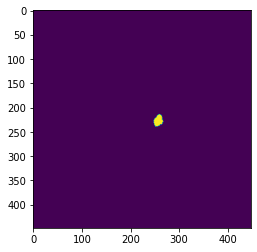

In [19]:
plt.imshow(labels[0][1].cpu().numpy())

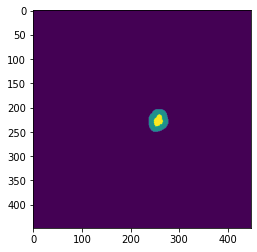

In [20]:
plt.imshow(halo[0][1].cpu().numpy())

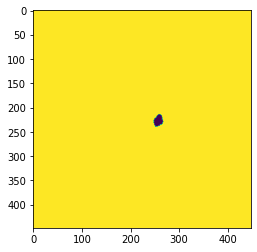

In [21]:
diff = halo[0][1] - labels[0][1]
plt.imshow(diff.cpu().numpy())

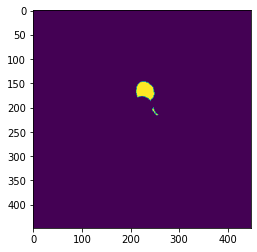

In [22]:
bg = labels[0][4] * halo[0][4]
plt.imshow(bg.cpu().numpy())